<a href="https://colab.research.google.com/github/stanley1208/AI-Learning/blob/main/Deep_Learning_Foundations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim

In [57]:
torch.manual_seed(0); np.random.seed(0)
X, y = make_moons(n_samples=400, noise=0.25, random_state=0)
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.30, random_state=0)


In [58]:
# Convert to tensors
Xtr = torch.tensor(Xtr, dtype=torch.float32)
ytr = torch.tensor(ytr, dtype=torch.float32).view(-1,1)
Xte  = torch.tensor(Xte,  dtype=torch.float32)
yte  = torch.tensor(yte,  dtype=torch.float32).view(-1,1)


In [59]:
class LogisticLogits(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear=nn.Linear(2,1)  # outputs logits
  def forward(self,x):
    return self.linear(x) # no sigmoid here

In [60]:
class TwoLayerLogits(nn.Module):
    def __init__(self, hidden=8, act="relu", dropout_p=0.0):
        super().__init__()
        self.fc1 = nn.Linear(2, hidden)
        self.fc2 = nn.Linear(hidden, 1)
        self.drop = nn.Dropout(dropout_p)
        if   act=="tanh":  self.act = nn.Tanh()
        elif act=="sigm":  self.act = nn.Sigmoid()
        else:              self.act = nn.ReLU()
    def forward(self, x):
        h = self.act(self.fc1(x))
        h = self.drop(h)
        return self.fc2(h)            # logits


In [61]:
loss_fn=nn.BCEWithLogitsLoss()

def acc_from_logits(model, X, y):
    with torch.no_grad():
        p = torch.sigmoid(model(X))          # convert logits → probabilities
        pred = (p >= 0.5).float()            # threshold → 0 or 1
        return pred.eq(y).float().mean().item()


In [62]:
def train_model(model, X, y, lr=0.01, epochs=300, weight_decay=0.0):
    opt = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    losses=[]
    for _ in range(epochs):
        logits = model(X)
        loss   = loss_fn(logits, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())
    return losses


In [63]:
hist={}
for lr in [0.001,0.01,0.1]:
  print(f"\n=== Training with learning rate {lr} ===")
  m=TwoLayerLogits(hidden=8,act="relu")
  hist[lr]=train_losses(m,X__train,y__train,lr)


=== Training with learning rate 0.001 ===
lr=0.001  epoch=50   loss=0.6933  acc=0.504
lr=0.001  epoch=100  loss=0.6921  acc=0.504
lr=0.001  epoch=150  loss=0.6909  acc=0.504
lr=0.001  epoch=200  loss=0.6897  acc=0.504
lr=0.001  epoch=250  loss=0.6885  acc=0.504
lr=0.001  epoch=300  loss=0.6872  acc=0.504

=== Training with learning rate 0.01 ===
lr=0.01   epoch=50   loss=0.6539  acc=0.700
lr=0.01   epoch=100  loss=0.6379  acc=0.693
lr=0.01   epoch=150  loss=0.6243  acc=0.696
lr=0.01   epoch=200  loss=0.6117  acc=0.700
lr=0.01   epoch=250  loss=0.5996  acc=0.704
lr=0.01   epoch=300  loss=0.5878  acc=0.714

=== Training with learning rate 0.1 ===
lr=0.1    epoch=50   loss=0.5574  acc=0.850
lr=0.1    epoch=100  loss=0.4169  acc=0.864
lr=0.1    epoch=150  loss=0.3538  acc=0.861
lr=0.1    epoch=200  loss=0.3340  acc=0.854
lr=0.1    epoch=250  loss=0.3266  acc=0.864
lr=0.1    epoch=300  loss=0.3227  acc=0.871


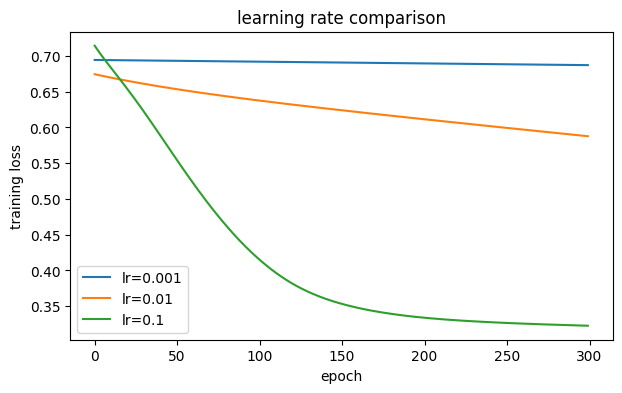

In [68]:
plt.figure(figsize=(7,4))
for lr,losses in hist.items():
  plt.plot(losses,label=f"lr={lr}")
plt.xlabel("epoch")
plt.ylabel("training loss")
plt.title("learning rate comparison")
plt.legend()
plt.show()

In [71]:
best_lr=0.1
H_over=16

def fit_eval(H,wd=0.0,epochs=300,lr=best_lr):
  m=TwoLayerLogits(hidden=H,act="relu",dropout_p=0.0)
  _=train_model(m,Xtr,ytr,lr=lr,epochs=epochs,weight_decay=wd)
  tr=acc_from_logits(m,Xtr,ytr)
  te=acc_from_logits(m,Xte,yte)
  return tr,te

print("---- L2 sweep ----")
l2_results=[]
for wd in [0.0,1e-4,1e-3,1e-2]:
  tr,te=fit_eval(H_over,wd=wd)
  l2_results.append((wd,tr,te))
  print(f"L2={wd:>6}  tr={tr:.3f}  te={te:.3f}")


# cap_results=[]
# for H in [2,4,8,16]:
#   tr,te=fit_eval(H)
#   cap_results.append((H,tr,te))
#   print(f"H={H:<2d}  tr={tr:.3f}  te={te:.3f}")

# # quick visual
# Hs,Tr,Te=zip(*cap_results)
# plt.figure(figsize=(6,3))
# plt.plot(Hs,Tr,"o-",label="train")
# plt.plot(Hs,Te,"o-",label="test")
# plt.xlabel("hidden")
# plt.ylabel("accuracy")
# plt.title("capacity vs accuracy")
# plt.legend()
# plt.show()

---- L2 sweep ----
L2=   0.0  tr=0.861  te=0.908
L2=0.0001  tr=0.857  te=0.908
L2= 0.001  tr=0.854  te=0.908
L2=  0.01  tr=0.854  te=0.900


In [77]:
print("---- Dropout sweep ----")

do_results=[]
for p in [0.0,0.1,0.2,0.9]:
  m=TwoLayerLogits(hidden=H,act="relu",dropout_p=p)
  _=train_model(m,Xtr,ytr,lr=lr,epochs=300,weight_decay=0.0)
  tr=acc_from_logits(m,Xtr,ytr)
  te=acc_from_logits(m,Xte,yte)
  do_results.append((p,tr,te))
  print(f"p={p:.1f}  tr={tr:.3f}  te={te:.3f}")

---- Dropout sweep ----
p=0.0  tr=0.861  te=0.908
p=0.1  tr=0.846  te=0.908
p=0.2  tr=0.861  te=0.917
p=0.9  tr=0.657  te=0.725


In [78]:
def train_with_optimizer(opt_name,lr=best_lr,epochs=300):
  m=TwoLayerLogits(hidden=H,act="relu")
  if opt_name=="sgd":
    opt=optim.SGD(m.parameters(),lr=lr)
  elif opt_name=="momentum":
    opt=optim.SGD(m.parameters(),lr=lr,momentum=0.9)
  elif opt_name=="adam":
    opt=optim.Adam(m.parameters(),lr=lr)
  else:
    raise ValueError("choose one of the optim")


  losses=[]
  for _ in range(epochs):
    logits=m(Xtr)
    loss=loss_fn(logits,ytr)
    opt.zero_grad()
    loss.backward()
    opt.step()
    losses.append(loss.item())

  tr=acc_from_logits(m,Xtr,ytr)
  te=acc_from_logits(m,Xte,yte)
  return losses,tr,te

optims=["sgd","momentum","adam"]
result={}

for name in optims:
  losses,tr,te=train_with_optimizer(name)
  result[name]=(losses,tr,te)
  print(f"{name}  tr={tr:.3f}  te={te:.3f}")

sgd  tr=0.861  te=0.908
momentum  tr=0.921  te=0.942
adam  tr=0.932  te=0.950


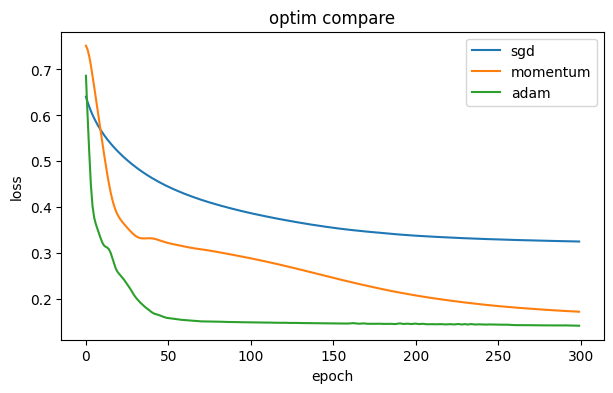

In [81]:
plt.figure(figsize=(7,4))
for name,(losses,tr,te) in result.items():
  plt.plot(losses,label=name)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("optim compare")
plt.legend()
plt.show()